In [1]:
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

In [2]:
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!pip install -q findspark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark as fs
fs.init()

In [7]:
import os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder \
    .appName("midterm") \
    .getOrCreate()

In [9]:
baskets = "/content/drive/MyDrive/Colab Notebooks/Data/baskets.csv"

# Task 1

In [10]:
def read_file(file_path):
    if not os.path.exists(file_path):
        return None
    return spark.sparkContext.textFile(file_path).distinct().map(lambda line: line.split(","))

In [11]:
def visualize(data, title, xlabel, ylabel):
    items, frequencies = zip(*data)
    plt.figure(figsize=(16, 8))
    plt.bar(items, frequencies)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

In [12]:
def save(result, function_name):
    folder_name = function_name.lower()
    file_name = "result.txt"
    folder_path = os.path.join(".", folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if result is None:
        return

    file_path = os.path.join(folder_path, file_name)

    with open(file_path, 'w') as file:
        if isinstance(result, tuple):
            for item in result:
                file.write(str(item) + '\n')
        elif isinstance(result, list):
            for item in result:
                file.write(str(item) + '\n')
        else:
            file.write(str(result) + '\n')


In [13]:
def f1(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None

    condition = lambda product: product.lower()

    distinct_product_names = rdd.map(lambda basket: basket[2]).distinct()
    distinct_product_names_sorted = distinct_product_names.sortBy(condition, ascending=True).take(10)

    top_ten_bt = distinct_product_names.sortBy(condition, ascending=False).take(10)[::-1]

    result = [distinct_product_names_sorted, top_ten_bt]

    save(result, "f1")

    return result

In [14]:
def f2(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None

    product_counts = rdd.map(lambda basket: (basket[2], 1)).reduceByKey(lambda a, b: a + b)
    sorted_products = product_counts.sortBy(lambda x: x[1], ascending=False)
    top_100_products = sorted_products.take(100)

    save(top_100_products, "f2")

    return top_100_products

In [15]:
def f3(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None
    count_sorted_basket = rdd.map(lambda line: ((line[0], line[1]), line[2])) \
                        .groupByKey()\
                        .mapValues(set)\
                        .map(lambda x: (x[0][0], 1)) \
                        .reduceByKey(lambda a, b: a + b) \
                        .sortBy(lambda item: item[1], ascending = False)


    sorted_members = count_sorted_basket.take(100)

    save(sorted_members, "f3")

    return sorted_members

In [16]:
def f4(file_path):
    rdd = read_file(file_path)

    if rdd is None:
        return None

    max_distinct_products_members = rdd.map(lambda line: (line[0], line[2])).groupByKey() \
                                       .mapValues(lambda x: len(set(x))) \
                                       .sortBy(lambda x: x[1], ascending=False) \
                                       .collect()

    max_distinct_products = max_distinct_products_members[0][1]
    top_members = [(member, count) for member, count in max_distinct_products_members if count == max_distinct_products]

    max_members_product = rdd.map(lambda line: (line[2], line[0]))\
                             .groupByKey()\
                             .mapValues(lambda x: len(set(x))).max(lambda x: x[1])


    result = [top_members, max_members_product[0], max_members_product[1]]
    save(result, "f4")

    return result


In [17]:
result_f1 = f1(baskets)

if result_f1[0] is not None:
    print("Top 10 products:\n")
    print("\n".join(result_f1[0]))

Top 10 products:

abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries
beverages
bottled beer


In [18]:
if result_f1[1] is not None:
    print("Bottom 10 products:\n")
    print("\n".join(result_f1[1]))

Bottom 10 products:

UHT-milk
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


In [19]:
result_f2 = f2(baskets)

if result_f2 is not None:
    print("Top 100 products with their frequencies:")
    for product, frequency in result_f2:
        print(f"{product}: {frequency}")

Top 100 products with their frequencies:
whole milk: 2363
other vegetables: 1827
rolls/buns: 1646
soda: 1453
yogurt: 1285
root vegetables: 1041
tropical fruit: 1014
bottled water: 908
sausage: 903
citrus fruit: 795
pastry: 774
pip fruit: 734
shopping bags: 712
canned beer: 702
bottled beer: 678
whipped/sour cream: 654
newspapers: 582
frankfurter: 565
brown bread: 563
domestic eggs: 555
pork: 555
butter: 527
fruit/vegetable juice: 509
beef: 508
curd: 504
margarine: 482
coffee: 473
frozen vegetables: 419
chicken: 417
white bread: 359
cream cheese : 354
chocolate: 353
dessert: 353
napkins: 331
hamburger meat: 327
berries: 326
UHT-milk: 320
onions: 303
salty snack: 281
waffles: 277
long life bakery product: 268
sugar: 265
butter milk: 263
ham: 256
meat: 252
frozen meals: 251
beverages: 248
specialty chocolate: 239
misc. beverages: 236
ice cream: 227
oil: 223
hard cheese: 220
grapes: 216
candy: 215
sliced cheese: 210
specialty bar: 209
hygiene articles: 205
chewing gum: 180
cat food: 177
wh

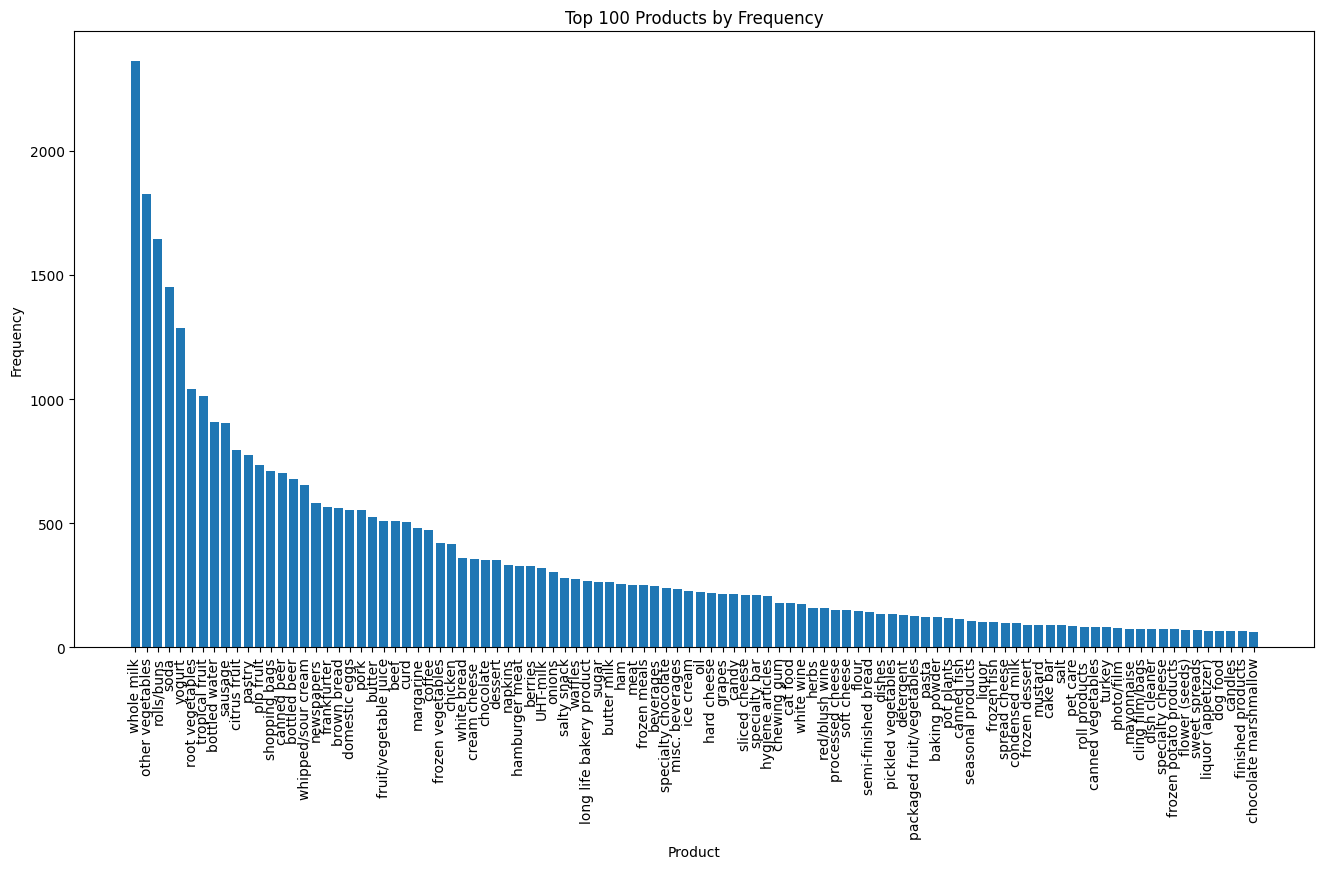

In [20]:
visualize(result_f2,'Top 100 Products by Frequency', "Product", 'Frequency')

In [21]:
result_f3 = f3(baskets)

if result_f3 is not None:
    print("Top 100 members with their number of baskets:")
    for member, count in result_f3:
        print(f"Member {member}: {count} baskets")

Top 100 members with their number of baskets:
Member 2271: 11 baskets
Member 4338: 11 baskets
Member 3737: 11 baskets
Member 1379: 11 baskets
Member 2193: 11 baskets
Member 1574: 10 baskets
Member 4217: 10 baskets
Member 2394: 10 baskets
Member 4864: 10 baskets
Member 2524: 10 baskets
Member 3180: 10 baskets
Member 3872: 10 baskets
Member 1793: 10 baskets
Member 3915: 10 baskets
Member 3120: 10 baskets
Member 4376: 10 baskets
Member 1052: 10 baskets
Member 1908: 10 baskets
Member 3289: 10 baskets
Member 3082: 10 baskets
Member 1410: 10 baskets
Member 2625: 10 baskets
Member 1275: 10 baskets
Member 3248: 10 baskets
Member 3593: 10 baskets
Member 3484: 10 baskets
Member 2851: 9 baskets
Member 4303: 9 baskets
Member 3830: 9 baskets
Member 1566: 9 baskets
Member 4683: 9 baskets
Member 1136: 9 baskets
Member 1169: 9 baskets
Member 4933: 9 baskets
Member 3050: 9 baskets
Member 2517: 9 baskets
Member 2164: 9 baskets
Member 1991: 9 baskets
Member 4272: 9 baskets
Member 3402: 9 baskets
Member 2

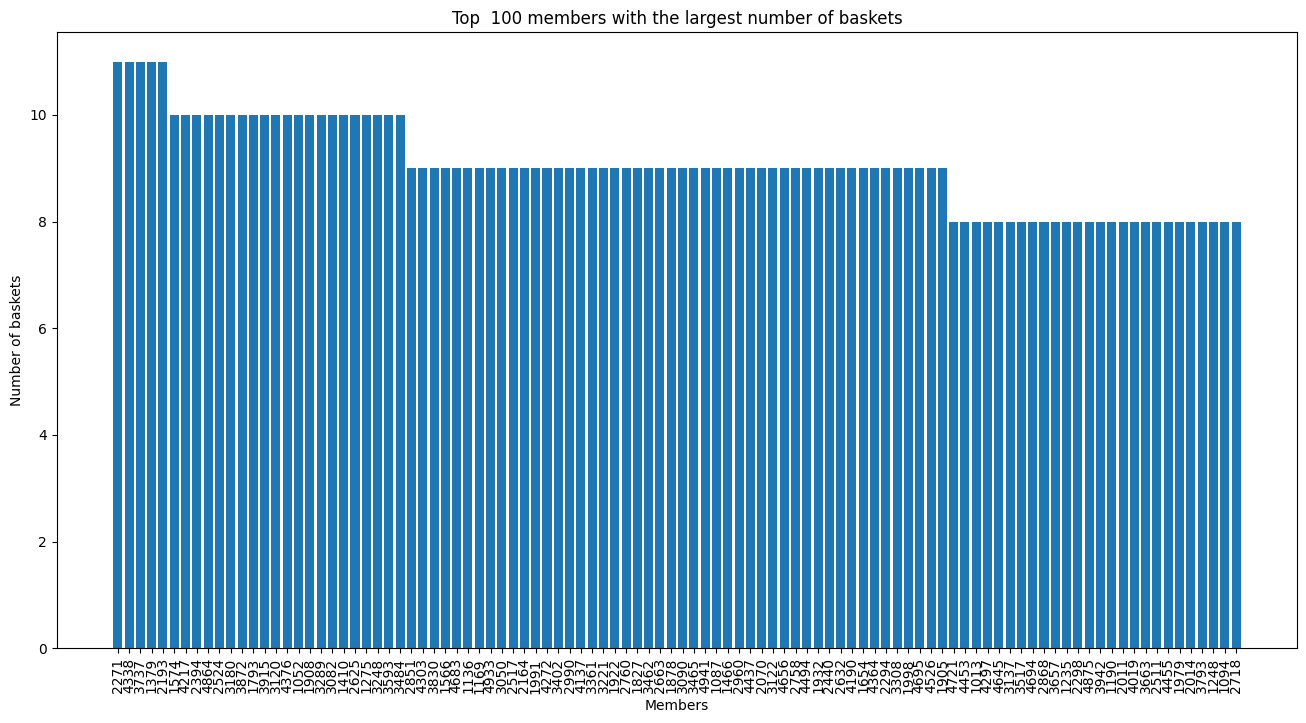

In [22]:
visualize(result_f3,'Top  100 members with the largest number of baskets', "Members", 'Number of baskets')

In [23]:
result_f4 = f4(baskets)

if result_f4 is not None:
    top_members, product, member_count = result_f4
    print("Members with the largest number of distinct products:")
    for member in top_members:
        print(f"Member: {member[0]}, Number of distinct products: {member[1]}")
    print("\nProduct bought by the most members:")
    print(f"Product: {product}, Number of members: {member_count}")

Members with the largest number of distinct products:
Member: 2051, Number of distinct products: 26
Member: 1379, Number of distinct products: 26

Product bought by the most members:
Product: whole milk, Number of members: 1786


# Task 2

In [24]:
from pyspark.sql.functions import *
from itertools import islice
from pyspark.sql.window import Window

In [25]:
df = spark.read.csv(baskets, header=True, inferSchema=True)

window_spec = Window.partitionBy("Member_number", "year", "month", "day")

df = df.withColumn("Basket", concat_ws(',',collect_set("itemDescription").over(window_spec))) \
      .dropDuplicates(["Member_number", "year", "month", "day", "Basket"]) \
      .select(["Member_number", "year", "month", "day", "Basket", "Date"]) \
      .orderBy("year", "month", "day")

df.select(["Member_number", "Date", "Basket", ]) \
  .show(truncate=False)

+-------------+----------+---------------------------------------------+
|Member_number|Date      |Basket                                       |
+-------------+----------+---------------------------------------------+
|4260         |01/01/2014|soda,brown bread                             |
|1440         |01/01/2014|yogurt,other vegetables                      |
|1789         |01/01/2014|candles,hamburger meat                       |
|3681         |01/01/2014|dishes,onions,whipped/sour cream             |
|3797         |01/01/2014|whole milk,waffles                           |
|2709         |01/01/2014|yogurt,frozen vegetables                     |
|2542         |01/01/2014|bottled water,sliced cheese                  |
|1381         |01/01/2014|curd,soda                                    |
|4942         |01/01/2014|butter,frozen vegetables                     |
|3942         |01/01/2014|yogurt,Instant food products,other vegetables|
|2226         |01/01/2014|sausage,bottled water    

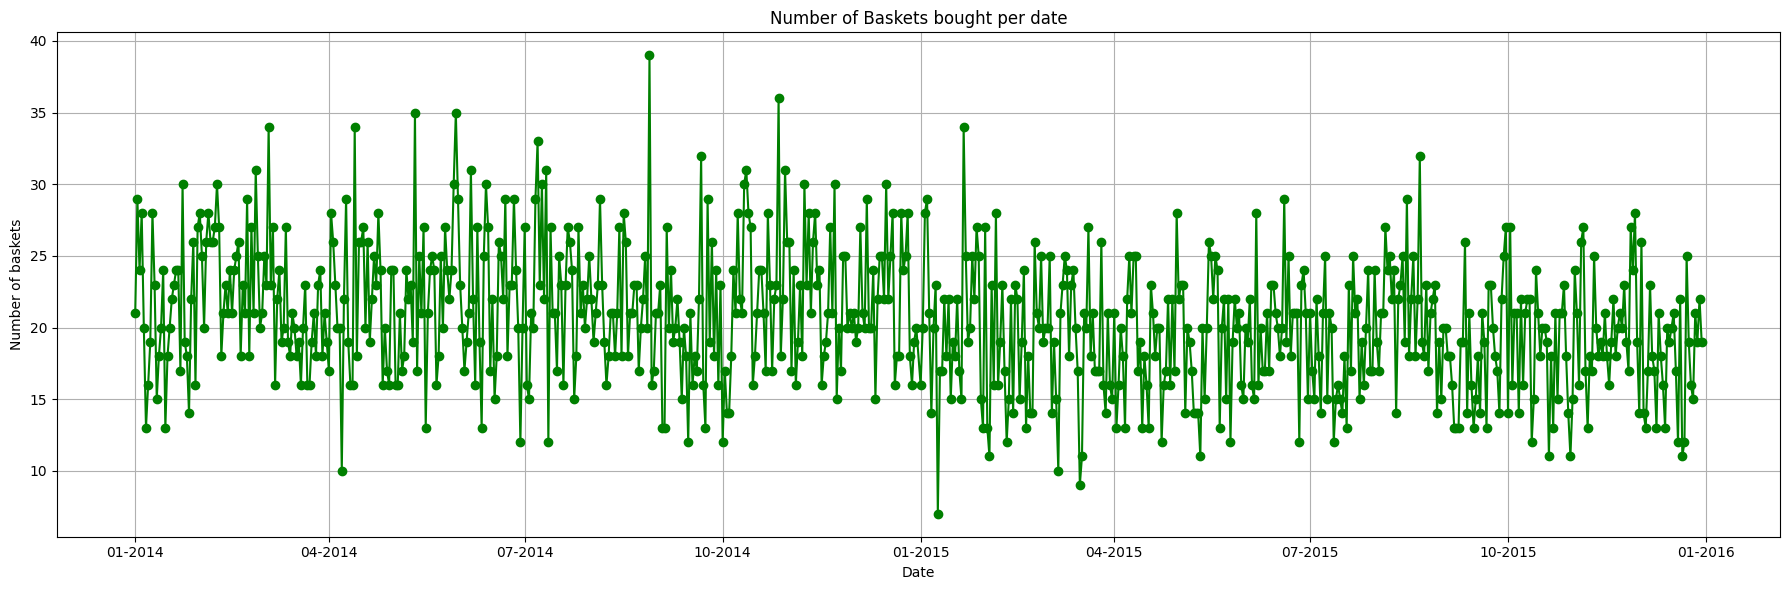

In [26]:
import matplotlib.dates as mdates
total_baskets_each_date = df.groupBy('Date') \
                                  .count() \
                                  .orderBy(to_date(col('Date'), 'dd/MM/yyyy'), ascendingOrder = True)


pdf = total_baskets_each_date.withColumn('Date', to_date(col('Date'), 'dd/MM/yyyy')).toPandas()
fig, ax = plt.subplots(figsize=(18, 6))

date = pdf['Date'].values.tolist()
baskets_count = pdf['count'].values.tolist()

date_form = mdates.DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.plot(date, baskets_count, marker='o', color='g')
plt.title("Number of Baskets bought per date")
plt.xlabel('Date')
plt.ylabel('Number of baskets')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df.select(["Member_number", "year", "month", "day", "Basket"]) \
  .write \
  .option("sep", ";") \
  .mode("overwrite") \
  .csv("baskets", header=True)

In [28]:
spark.stop()

In [39]:
!cat /content/baskets/part-00000-5802b9a8-c7d7-4eb6-a05e-e3c18a6a2373-c000.csv

Member_number;year;month;day;Basket
2974;2014;1;1;bottled water,berries,whipped/sour cream
1249;2014;1;1;citrus fruit,coffee
1922;2014;1;1;tropical fruit,other vegetables
2727;2014;1;1;hamburger meat,frozen potato products
2237;2014;1;1;Instant food products,bottled water
1381;2014;1;1;curd,soda
1659;2014;1;1;specialty chocolate,frozen vegetables
3956;2014;1;1;yogurt,shopping bags,waffles,chocolate
2709;2014;1;1;yogurt,frozen vegetables
2351;2014;1;1;shopping bags,cleaner
2943;2014;1;1;whole milk,flower (seeds)
4942;2014;1;1;butter,frozen vegetables
3681;2014;1;1;dishes,onions,whipped/sour cream
3942;2014;1;1;yogurt,Instant food products,other vegetables
2226;2014;1;1;sausage,bottled water
3797;2014;1;1;whole milk,waffles
1440;2014;1;1;yogurt,other vegetables
1789;2014;1;1;candles,hamburger meat
2542;2014;1;1;bottled water,sliced cheese
4260;2014;1;1;soda,brown bread
2610;2014;1;1;domestic eggs,bottled beer,hamburger meat
2043;2014;1;2;waffles,brown bread
4014;2014;1;2;shopping bags,so

# Task 3

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.types import *
class PCY():
    def __init__(self,path: str, S: float, C: float, bucket_size: int = 5000):
        self.spark = SparkSession.builder.appName("PCY").getOrCreate()
        self.sc = self.spark.sparkContext
        self.path=path
        self.S = S
        self.C = C
        self.baskets_df = self.read_baskets()
        self.item = self.baskets_df.select(explode(self.baskets_df["Basket"]) \
                                        .alias("item"))
        self.total_baskets = self.baskets_df.count()
        self.bucket_size = bucket_size

    def read_baskets(self):
        baskets_df = self.spark.read.csv(self.path,
                                        header=True,
                                        inferSchema=True,
                                        sep=';')

        baskets_df = baskets_df.withColumn("Basket",
                                          split(baskets_df["Basket"], ","))
        return baskets_df

    def save(self, frequent_pairs: DataFrame, association_rules: DataFrame):
        frequent_pairs.withColumn("items", concat_ws(",", col("items"))) \
                .write.mode("overwrite") \
                .option("sep", ";") \
                .csv('pcy_frequent_pairs.csv', header=True)

        association_rules.write.mode("overwrite") \
                .option("sep", ";") \
                .csv('pcy_association_rules.csv', header=True)

    def delete(self):
        self.spark.stop()

    def find_frequent_items(self):
        return self.item.groupBy('item').agg(count('*').alias('count')) \
                  .withColumn('support', col('count') / self.total_baskets) \
                  .filter(col('support') >= self.S)

    def _generate_pairs(self, frequent_items_df):
        return frequent_items_df.alias("df1").join(
                  frequent_items_df.alias("df2"),
                  col("df1.item") < col("df2.item")
              ).select(
                  col("df1.item").alias("item1"),
                  col("df2.item").alias("item2")
              )

    def generate_frequent_pairs(self, frequent_items_df):
        pairs = self._generate_pairs(frequent_items_df)

        hash_value_expr = abs(hash(concat_ws('\t', *pairs.columns)) % self.bucket_size)
        pairs = pairs.withColumn('hash_value', hash_value_expr)

        hash_df = pairs.groupBy('hash_value').count()

        hash_df = hash_df.filter((col("count") / self.total_baskets) >= self.S)
        hash_dict = hash_df.rdd.collectAsMap()

        if not hash_dict:
            return self.spark.createDataFrame([], StructType([
                StructField('items', ArrayType(StringType()), True),
                StructField('freq', IntegerType(), True)
            ]))

        basket = self.baskets_df.select('Basket')

        frequent_pairs = basket.alias("b") \
            .join(pairs.alias("p"),
                  (array_contains(col("b.Basket"), col("p.item1"))) &
                  (array_contains(col("b.Basket"), col("p.item2")))) \
            .filter(col('p.hash_value').isin(list(hash_dict.keys()))) \
            .groupBy(col("p.item1"), col("p.item2")) \
            .count() \
            .withColumnRenamed("count", "freq") \
            .selectExpr("array(item1, item2) as items", "freq")

        return frequent_pairs

    def generate_association_rules(self, frequent_items_df, frequent_pairs):
        assoc_rules_df = frequent_pairs.select(
            frequent_pairs['items'][1].alias('antecedent'),
            frequent_pairs['items'][0].alias('consequent'),
            frequent_pairs['freq']
        ).withColumn(
            'support',
            col('freq') / self.total_baskets
        ).union(
            frequent_pairs.select(
                frequent_pairs['items'][0].alias('antecedent'),
                frequent_pairs['items'][1].alias('consequent'),
                frequent_pairs['freq']
            ).withColumn(
                'support',
                col('freq') / self.total_baskets
            )
        )

        assoc_rules_df = assoc_rules_df.join(
            broadcast(frequent_items_df),
            on=(assoc_rules_df['antecedent'] == frequent_items_df['item']),
            how='inner'
        ).select(
            'antecedent',
            'consequent',
            'freq',
            assoc_rules_df['support'].alias('support'),
            frequent_items_df['support'].alias('antecedent_support')
        ).withColumn(
            'confidence',
            col('support') / col('antecedent_support')
        )

        return assoc_rules_df.drop('antecedent_support', 'freq') \
                          .filter(assoc_rules_df.support >= self.S) \
                          .filter(assoc_rules_df.confidence >= self.C)

    def run(self):
        frequent_items_df = self.find_frequent_items()
        frequent_pairs = self.generate_frequent_pairs(frequent_items_df)
        association_rules = self.generate_association_rules(frequent_items_df, frequent_pairs)

        association_rules = association_rules.orderBy(col("antecedent"), col("consequent"))

        self.save(frequent_pairs, association_rules)

        return frequent_pairs, association_rules

In [31]:
pcy = PCY('baskets',S = 2E-4, C = .5)
frequent_pairs, association_rules = pcy.run()

In [32]:
print("Frequent Itemsets:")
frequent_pairs.show(truncate=False)

Frequent Itemsets:
+---------------------------------------+----+
|items                                  |freq|
+---------------------------------------+----+
|[meat, white wine]                     |1   |
|[meat, other vegetables]               |32  |
|[frankfurter, pudding powder]          |1   |
|[frankfurter, waffles]                 |7   |
|[canned vegetables, turkey]            |1   |
|[cream cheese , white wine]            |2   |
|[potato products, specialty bar]       |1   |
|[other vegetables, specialty cheese]   |4   |
|[beef, salt]                           |2   |
|[flower soil/fertilizer, soda]         |1   |
|[hard cheese, instant coffee]          |1   |
|[roll products, seasonal products]     |2   |
|[packaged fruit/vegetables, popcorn]   |1   |
|[packaged fruit/vegetables, pot plants]|1   |
|[packaged fruit/vegetables, pip fruit] |5   |
|[citrus fruit, pudding powder]         |1   |
|[chicken, sparkling wine]              |2   |
|[butter, ketchup]                      |

In [33]:
print("Filtered Association Rules:")
association_rules.show(truncate=False)

Filtered Association Rules:
+--------------+-----------+---------------------+----------+
|antecedent    |consequent |support              |confidence|
+--------------+-----------+---------------------+----------+
|cream cheese  |whole milk |0.0013366303548753592|0.5       |
|roll products |hard cheese|2.0049455323130388E-4|0.6       |
+--------------+-----------+---------------------+----------+



In [34]:
pcy.delete()